In [1]:
# import mnist
from torchvision.datasets import MNIST
import torch
import torch.nn as nn
import torch.nn.functional as F
# import dataloader
import torchvision
import torchvision.transforms as transforms
import tqdm
import random
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np

import torch.optim as optim
import os

from joblib import Parallel, delayed
import pickle
from torchprofile import profile_macs

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt



In [2]:
BATCH_SIZE = 64
lr=0.01
epochs = 10


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

MNIST_TRAIN_DATA = MNIST(root='./data', train=True, download=True, transform=transform)
MNIST_TEST = MNIST(root='./data', train=False, download=True, transform=transform)
train_val_fraction = [0.9, 0.1]
mnist_val = random_split(MNIST_TRAIN_DATA, train_val_fraction)
mnist_train = mnist_val[0]
mnist_val = mnist_val[1]

train_dataloader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(mnist_val, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(MNIST_TEST, batch_size=BATCH_SIZE, shuffle=True)


In [4]:
class MyNet(nn.Module):
  def __init__(self):
    super(MyNet, self).__init__()

    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # 1x28x28
    self.maxpool1 = nn.MaxPool2d(2)  # 10x12x12
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)  # 20x8x8
    self.maxpool2 = nn.MaxPool2d(2)  # 20x4x4
    self.linear2 = nn.Linear(20*4*4, 64)
    self.linear3 = nn.Linear(64, 10)

  def forward(self, x):
    x = F.relu(self.maxpool1(self.conv1(x)))
    x = F.relu(self.maxpool2(self.conv2(x)))
    x = x.view(-1, 20*4*4)
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x


In [5]:
net = MyNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = net.to(device)
optimzer = torch.optim.Adam(model.parameters(), lr=lr)


for epoch in tqdm.tqdm(range(epochs)):
  for batch_idx, (data, target) in enumerate(train_dataloader):
    data, target = data.to(device), target.to(device)
    optimzer.zero_grad()
    output = net(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimzer.step()


final_accuracy = []
qtd = 0
correct = 0
for data, target in test_dataloader:
  data, target = data.to(device), target.to(device)
  output = net(data)
  pred = output.max(1, keepdim=True)[1]
  correct += pred.eq(target.view_as(pred)).sum().item()

print(correct/len(test_dataloader.dataset))


100%|██████████| 10/10 [02:56<00:00, 17.61s/it]


0.9741


# Exercise 2

Training for a single epoch only, vary the model size and dataset size. For the model size, multiply the width by powers of sqrt(2) (rounding if necessary - the idea is to vary the amount of compute used per forward pass by powers of 2). For the dataset size, multiply the fraction of the full dataset used by powers of 2 (i.e. 1, 1/2, 1/4, ...). To reduce noise, use a few random seeds and always use the full validation set.

# Exercise 3

The learning rate will need to vary with model size. Either tune it carefully for each model size, or use the rule of thumb that for Adam, the learning rate should be proportional to the initialization scale, i.e. 1/sqrt(fan_in) for the standard Kaiming He initialization (which is what PyTorch generally uses by default).

(Here we used D.1 Equation of the refered paper: $LR(N) ≈ 0.003239 + −0.0001395 \log(N))$

In [6]:
class MyNet(nn.Module):
    def __init__(self, out_channels_1=10, out_channels_2=20, neurons=64, dropout=None):
        super(MyNet, self).__init__()
        self.out_channels_1 = out_channels_1
        self.out_channels_2 = out_channels_2
        self.neurons = neurons
        self.dropout = dropout

        self.conv1 = nn.Conv2d(1, self.out_channels_1, kernel_size=5)  # 1x28x28
        self.maxpool1 = nn.MaxPool2d(2)  # 10x12x12
        self.conv2 = nn.Conv2d(self.out_channels_1, self.out_channels_2, kernel_size=5)  # 20x8x8
        self.maxpool2 = nn.MaxPool2d(2)  # 20x4x4
        self.linear2 = None
        self.linear3 = nn.Linear(self.neurons, 10)

        # Initialize dropout layer if dropout is specified
        if self.dropout:
            self.dropout_layer = nn.Dropout(self.dropout)
        else:
            self.dropout_layer = None

        self.__initialize_dimensions()

    def __initialize_dimensions(self):
        dummy = torch.randn(1, 1, 28, 28)
        out = self.maxpool1(self.conv1(dummy))
        out = self.maxpool2(self.conv2(out))

        self.linear2 = nn.Linear(out.size()[1]*out.size()[2]*out.size()[3], self.neurons)

    def forward(self, x):
        x = F.relu(self.maxpool1(self.conv1(x)))
        if self.dropout_layer:
            x = self.dropout_layer(x)  # Apply dropout after the first convolutional layer
        x = F.relu(self.maxpool2(self.conv2(x)))
        if self.dropout_layer:
            x = self.dropout_layer(x)  # Apply dropout after the second convolutional layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.linear2(x))
        if self.dropout_layer:
            x = self.dropout_layer(x)  # Apply dropout after the first linear layer
        x = self.linear3(x)
        return x

In [7]:
num_epochs = 1
learning_rate = 0.001
validation_split = 0.1
sqrt2 = np.sqrt(2)

model_sizes = [sqrt2, sqrt2**2, sqrt2**3]
random_seeds = [0, 1, 2]
dataset_fractions = [1, 0.5, 0.25, 0.125]
INITIAL_MODEL_SIZES = [10, 20, 64]

config = [(random_seed, model_size, dataset_fraction)
          for random_seed in random_seeds
          for model_size in model_sizes
          for dataset_fraction in dataset_fractions]


In [8]:
# check if it's possible to load each model
def load_models():
  models_loaded = []
  for m in config:
    model_path = f"model_{m[0]}_{int(m[1])}_{m[2]}.pt"
    print(model_path)
    if os.path.exists(model_path):
      model = MyNet()
      model.load_state_dict(torch.load(model_path))
      models_loaded.append(model)
  return models_loaded




In [9]:

FULL_TEST_LEN = len(MNIST_TEST)
FULL_TRAIN_LEN = len(MNIST_TRAIN_DATA)
print(FULL_TEST_LEN, FULL_TRAIN_LEN)

train_val_fraction = [0.9, 0.1]
torch.manual_seed(0)
TRAIN_VAL_SPLIT = random_split(MNIST_TRAIN_DATA, train_val_fraction)
TRAIN_DATA_TO_CROP = TRAIN_VAL_SPLIT[0]

FIXED_VAL_DATA = TRAIN_VAL_SPLIT[1]
fixed_val_loader = DataLoader(FIXED_VAL_DATA, shuffle=False, batch_size=BATCH_SIZE, pin_memory=True)




# results = []

def train_and_evaluate(random_seed, model_size, dataset_fraction, dropout=None):
    torch.manual_seed(random_seed)
    random.seed(random_seed)

    FRACTION_USED = int(len(TRAIN_DATA_TO_CROP) * dataset_fraction)
    indices = torch.randperm(len(TRAIN_DATA_TO_CROP))[:FRACTION_USED]
    TRAIN_DATA = Subset(TRAIN_DATA_TO_CROP, indices)

    train_loader = DataLoader(TRAIN_DATA, shuffle=True, batch_size=BATCH_SIZE, pin_memory=True)

    model = MyNet(out_channels_1=int(model_size * INITIAL_MODEL_SIZES[0]),
                  out_channels_2=int(model_size * INITIAL_MODEL_SIZES[1]),
                  neurons=int(model_size * INITIAL_MODEL_SIZES[2]), 
                  dropout=dropout)

    model = model.to(device)

    # save model

    N = sum(p.numel() for p in model.parameters())
    # Equation D1 of the paper
    model_lr = 0.003239 - 0.0001395*np.log(N)

    optimizer = optim.Adam(model.parameters(), lr=model_lr)

    iteration_results = []
    model.train()
    cumulative_flops = 0

    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate FLOPs/2=macs for the current forward pass using torchprofile
            flops = 2*profile_macs(model, images)
            cumulative_flops += flops
            # Record FLOPs/2=macs and loss for this iteration
            iteration_results.append((cumulative_flops, loss.item()))

    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in fixed_val_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / len(fixed_val_loader.dataset)
    return (random_seed, model_size, dataset_fraction, accuracy, model, iteration_results)


10000 60000


In [ ]:
models_loaded = load_models()

if not models_loaded:

  results  = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(random_seed, model_size, dataset_fraction) for random_seed, model_size, dataset_fraction in config)
  # save the models
  models_to_save = [result[4] for result in results]
  # save each of the models
  for i, model in enumerate(models_to_save):
    model_path = f"model_{config[i][0]}_{int(config[i][1])}_{config[i][2]}.pt"
    torch.save(model.state_dict(), model_path)

  with open("results.pkl", "wb") as f:
      pickle.dump(results, f)

else:
  print("Models already loaded")
  with open("results.pkl", "rb") as f:
      results = pickle.load(f)



In [11]:
with open("results.pkl", "rb") as f:
    results = pickle.load(f)

In [12]:

max_acc = max(results, key=lambda x: x[3])
print(f"Max Accuracy: {max_acc[3]}")
print(f"Random Seed: {max_acc[0]}, Model Size: {[int(max_acc[1]* param) for param in model_sizes]}, Dataset Fraction: {max_acc[2]}, Final Loss: {max_acc[5][-1][1]}, FLOPs: {max_acc[5][-1][0]}")

Max Accuracy: 0.9858333333333333
Random Seed: 2, Model Size: [2, 4, 5], Dataset Fraction: 1, Final Loss: 0.0782349556684494, FLOPs: 178329600000


# 4 Plot the amount of compute used (on a log scale) against validation loss. The compute-efficient frontier should follow an approximate power law (straight line on a log scale).

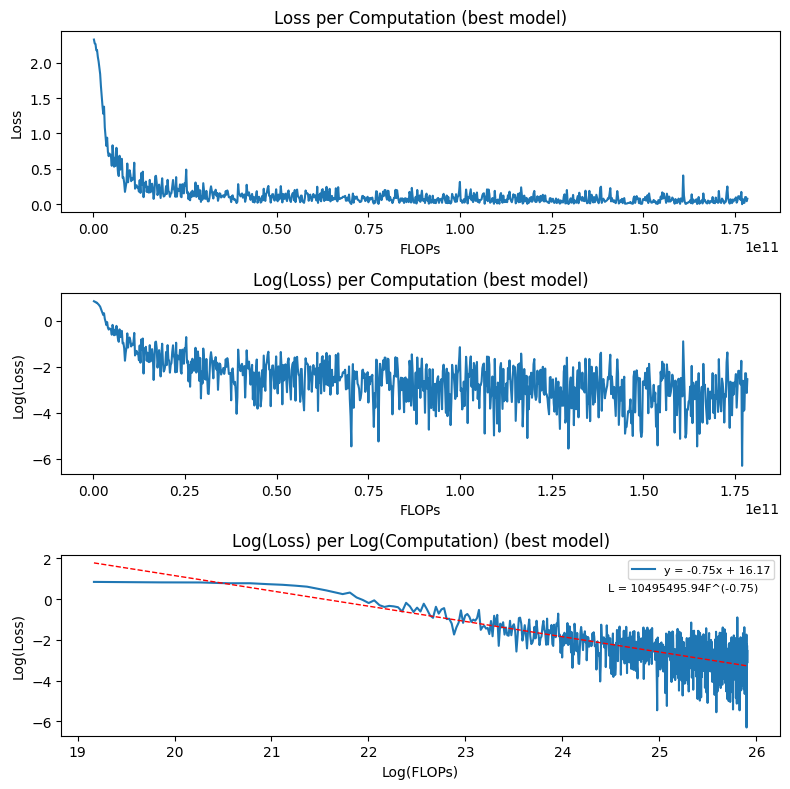

In [13]:
flops_values = [max_acc[5][i][0] for i in range(len(max_acc[5]))]
loss_values = [max_acc[5][i][1] for i in range(len(max_acc[5]))]

fig, ax = plt.subplots(3, 1, figsize=(8, 8))
ax[0].plot(flops_values, loss_values)
ax[0].set_xlabel('FLOPs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss per Computation (best model)')

ax[1].plot(flops_values, np.log(loss_values))
ax[1].set_xlabel('FLOPs')
ax[1].set_ylabel('Log(Loss)')
ax[1].set_title('Log(Loss) per Computation (best model)')

ax[2].plot(np.log(flops_values), np.log(loss_values))
ax[2].set_xlabel('Log(FLOPs)')
ax[2].set_ylabel('Log(Loss)')
ax[2].set_title('Log(Loss) per Log(Computation) (best model)')
plt.tight_layout()

# add the line fit to th log-log plot
x = np.log(flops_values)
y = np.log(loss_values)
m, b = np.polyfit(x, y, 1)
ax[2].plot(x, m*x + b, color='red', linestyle='--', linewidth=1,  label='y = {:.2f}x + {:.2f}'.format(m, b))
ax[2].legend(['y = {:.2f}x + {:.2f}'.format(m, b)], fontsize=8)
# add the powerlaw L=af^b to the log-log plot
A = np.exp(b)
B = m
ax[2].text(0.76, 0.8, f'L = {A:.2f}F^({B:.2f})', fontsize=8, transform=ax[2].transAxes)

plt.tight_layout()

plt.show()


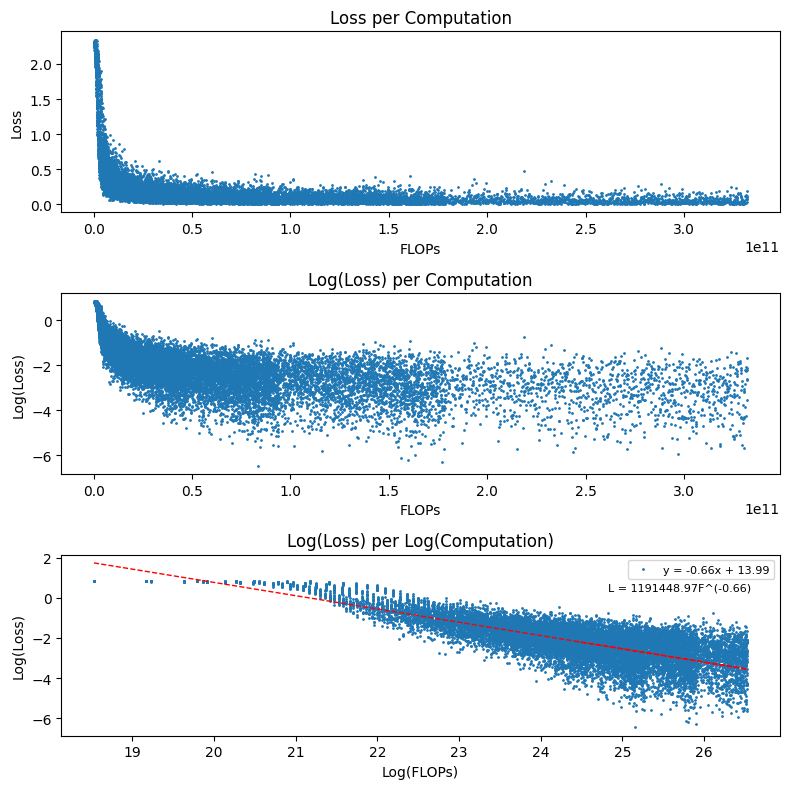

In [14]:
# Plot the amount of compute used (on a log scale) against validation loss. The compute-efficient frontier should follow an approximate power law (straight line on a log scale).


def plot_loss_vs_flops(all_flops, all_losses, MK_SIZE = 1, title=""):
    

    fig, ax = plt.subplots(3, 1, figsize=(8, 8))
    ax[0].plot(all_flops, all_losses, 'o', markersize=MK_SIZE)
    ax[0].set_xlabel('FLOPs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title(title+'Loss per Computation')

    ax[1].plot(all_flops, np.log(all_losses), 'o', markersize=MK_SIZE)
    ax[1].set_xlabel('FLOPs')
    ax[1].set_ylabel('Log(Loss)')
    ax[1].set_title(title+'Log(Loss) per Computation')

    ax[2].plot(np.log(all_flops), np.log(all_losses), 'o', markersize=MK_SIZE)
    ax[2].set_xlabel('Log(FLOPs)')
    ax[2].set_ylabel('Log(Loss)')
    ax[2].set_title(title+'Log(Loss) per Log(Computation)')
    plt.tight_layout()

    # add the line fit to th log-log plot
    x = np.log(all_flops)
    y = np.log(all_losses)
    m, b = np.polyfit(x, y, 1)
    ax[2].plot(x, m*x + b, color='red', linestyle='--', linewidth=1,  label='y = {:.2f}x + {:.2f}'.format(m, b))
    ax[2].legend(['y = {:.2f}x + {:.2f}'.format(m, b)], fontsize=8)
    # add the powerlaw L=af^b to the log-log plot
    A = np.exp(b)
    B = m
    ax[2].text(0.76, 0.8, f'L = {A:.2f}F^({B:.2f})', fontsize=8, transform=ax[2].transAxes)

    plt.tight_layout()

    plt.show()

all_flops = []
all_losses = []

for result in results:
    flops_values = [result[5][i][0] for i in range(len(result[5]))]
    loss_values = [result[5][i][1] for i in range(len(result[5]))]
    all_flops.extend(flops_values)
    all_losses.extend(loss_values)

plot_loss_vs_flops(all_flops, all_losses)


In [15]:
len(results)

36

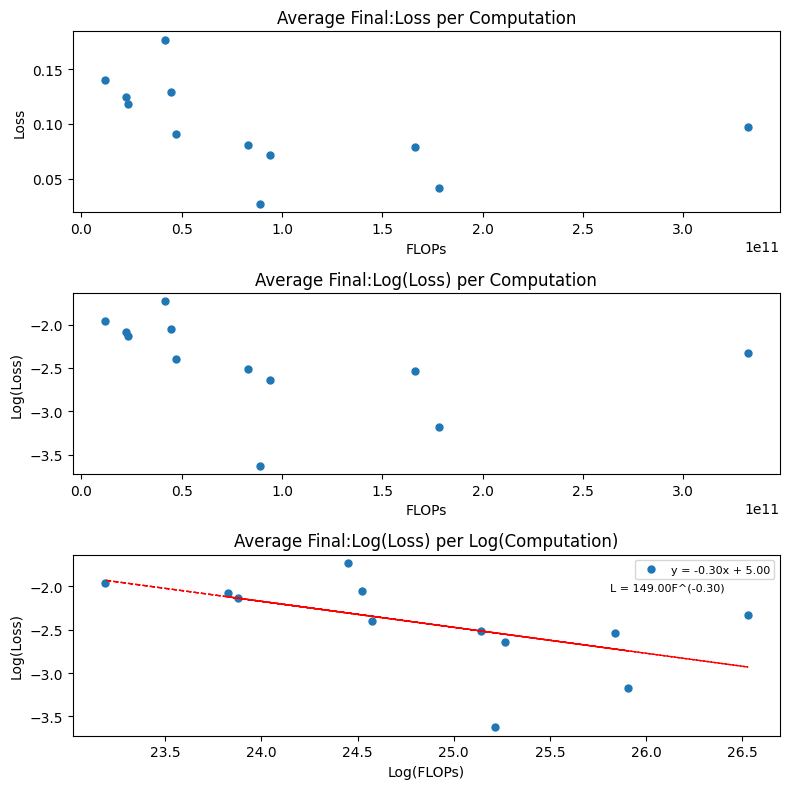

In [16]:
# for each model_size and dataset fraction, average the final loss, accuacy and compute over the random seeds
results_without_model_with_final_loss = [(result[0], result[1], result[2], result[3], result[5][-1][0], result[5][-1][1]) for result in results]

average_results = []
for model_size in model_sizes:
    for dataset_fraction in dataset_fractions:
        results_for_model_size_and_dataset_fraction = [result for result in results_without_model_with_final_loss if result[1] == model_size and result[2] == dataset_fraction]
        average_loss = np.mean([result[5] for result in results_for_model_size_and_dataset_fraction])
        average_flops = np.mean([result[4] for result in results_for_model_size_and_dataset_fraction])
        average_accuracy = np.mean([result[3] for result in results_for_model_size_and_dataset_fraction])
        average_results.append((model_size, dataset_fraction, average_accuracy, average_flops, average_loss))

# for result in average_results:
    # print(f"Model Size factor: {result[0]}, Dataset Fraction: {result[1]}, Average Accuracy: {result[2]}, Average FLOPs: {result[3]}, Average Loss: {result[4]}")

# plot the average loss vs average flops
average_flops = [result[3] for result in average_results]
average_loss = [result[4] for result in average_results]

plot_loss_vs_flops(average_flops, average_loss, MK_SIZE=5, title='Average Final:')

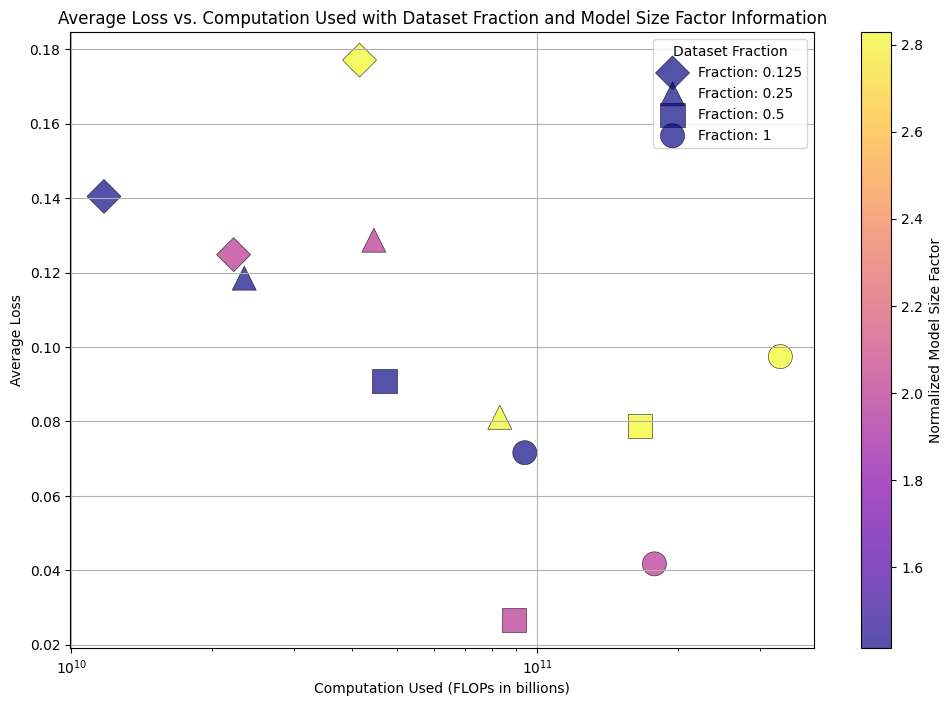

In [17]:

def plot_big_graph(average_results, model_sizes):
    params, fractions, accuracies, flops, losses = zip(*average_results)

    norm_params = params

    fraction_markers = {
        1: 'o',      
        0.5: 's',    
        0.25: '^',   
        0.125: 'D'  
    }

    plt.figure(figsize=(12, 8))

    for frac in sorted(set(fractions)):
        frac_data = [(fl, ls, ns) for p, f, a, fl, ls, ns in zip(params, fractions, accuracies, flops, losses, norm_params) if f == frac]
        flops_subset, losses_subset, norm_params_subset = zip(*frac_data)
        plt.scatter(flops_subset, losses_subset, s=300, c=norm_params_subset, cmap='plasma', alpha=0.7, edgecolors='k', linewidth=0.5, marker=fraction_markers[frac], label=f'Fraction: {frac}')

    plt.xlabel('Computation Used (FLOPs in billions)')
    plt.ylabel('Average Loss')
    plt.title('Average Loss vs. Computation Used with Dataset Fraction and Model Size Factor Information')

    cbar = plt.colorbar()
    cbar.set_label('Normalized Model Size Factor')

    plt.legend(title='Dataset Fraction')
    plt.grid(True)
    plt.xscale('log') 
    plt.show()

plot_big_graph(average_results, model_sizes)


# 5 - How does validation accuracy behave?


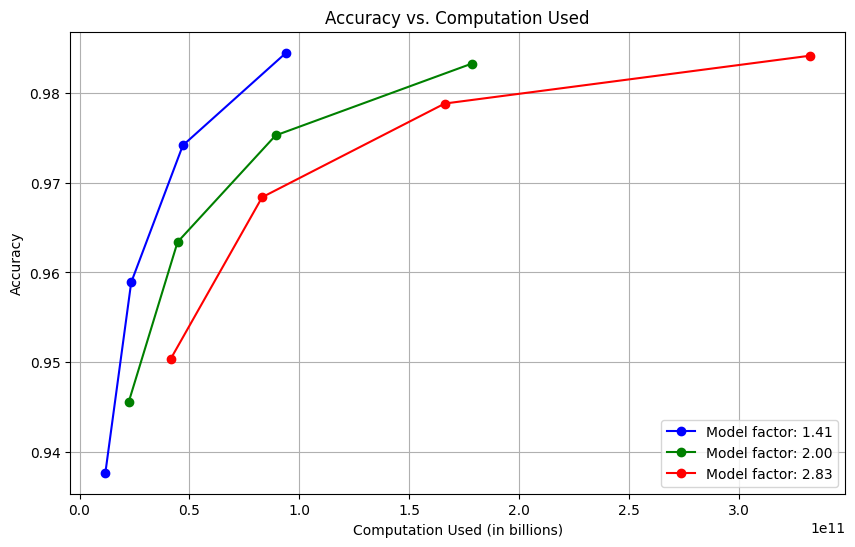

In [18]:

def plot_accuracy_per_computation(average_results):
    params, fractions, accuracies, computations, loss = zip(*average_results)
    losses = [1 - accuracy for accuracy in accuracies]

    # Unique model parameters
    unique_params = sorted(set(params))

    # Colors for different model parameters
    colors = ['b', 'g', 'r']

    plt.figure(figsize=(10, 6))

    for i, p in enumerate(unique_params):
        indices = [j for j, x in enumerate(params) if x == p]
        plt.plot([computations[j] for j in indices], [accuracies[j] for j in indices], 
                 label=f'Model factor: {p:.2f}', color=colors[i], marker='o')

    plt.xlabel('Computation Used (in billions)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Computation Used')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_accuracy_per_computation(average_results)


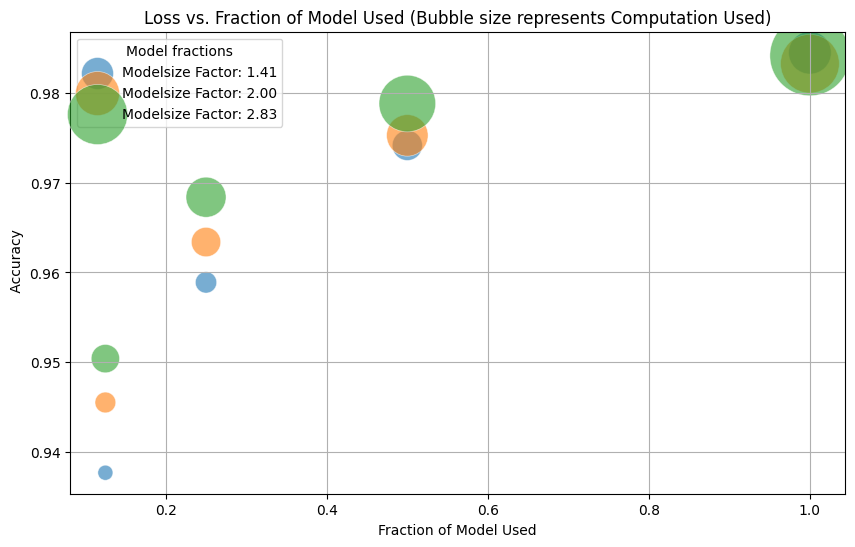

In [19]:

def bubble_plot(data):
    params, fractions, accuracies, computations, loss = zip(*data)

    computations_b = [comp / 1e9 for comp in computations]

    plt.figure(figsize=(10, 6))

    for i, p in enumerate(sorted(set(params))):
        indices = [j for j, x in enumerate(params) if x == p]
        plt.scatter([fractions[j] for j in indices], 
                    [accuracies[j] for j in indices], 
                    s=[computations_b[j] * 10 for j in indices], 
                    alpha=0.6, 
                    label=f'Modelsize Factor: {p:.2f}', 
                    edgecolors='w', 
                    linewidth=0.5)

    plt.xlabel('Fraction of Model Used')
    plt.ylabel(' Accuracy')
    plt.title('Loss vs. Fraction of Model Used (Bubble size represents Computation Used)')
    plt.legend(title='Model fractions')
    plt.grid(True)
    plt.show()

bubble_plot(average_results)


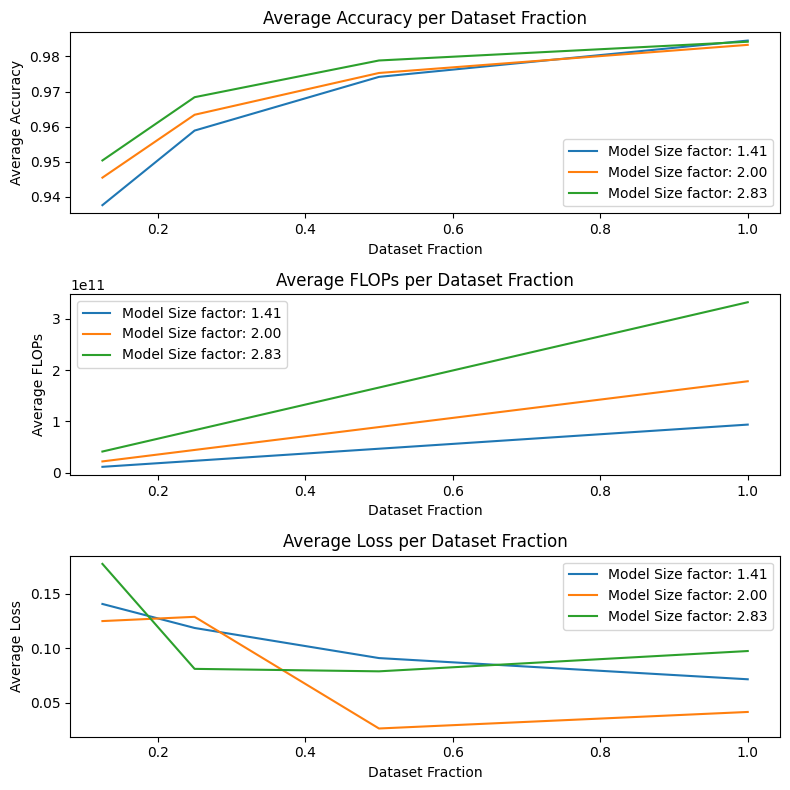

In [20]:

# plot the average results
def average_acc_per_dataset_fraction(average_results, model_sizes):

    fig, ax = plt.subplots(3, 1, figsize=(8, 8))
    for model_size in model_sizes:
        results_for_model_size = [result for result in average_results if result[0] == model_size]
        ax[0].plot([result[1] for result in results_for_model_size], [result[2] for result in results_for_model_size], label=f"Model Size factor: {model_size:.2f}")
        ax[1].plot([result[1] for result in results_for_model_size], [result[3] for result in results_for_model_size], label=f"Model Size factor: {model_size:.2f}")
        ax[2].plot([result[1] for result in results_for_model_size], [result[4] for result in results_for_model_size], label=f"Model Size factor: {model_size:.2f}")

    ax[0].set_xlabel('Dataset Fraction')
    ax[0].set_ylabel('Average Accuracy')
    ax[0].set_title('Average Accuracy per Dataset Fraction')

    ax[1].set_xlabel('Dataset Fraction')
    ax[1].set_ylabel('Average FLOPs')
    ax[1].set_title('Average FLOPs per Dataset Fraction')

    ax[2].set_xlabel('Dataset Fraction')
    ax[2].set_ylabel('Average Loss')
    ax[2].set_title('Average Loss per Dataset Fraction')

    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.tight_layout()
    plt.show()

average_acc_per_dataset_fraction(average_results, model_sizes)
    

# 5 - Study how the compute-efficient model size varies with compute. This should also follow an approximate power law. Try to estimate its exponent.


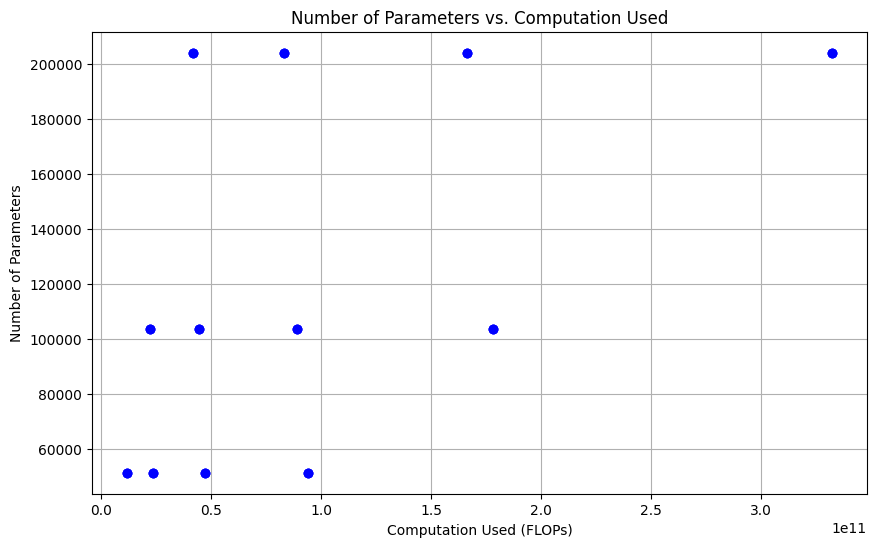

In [143]:
# we will study how Neff (number of parameteres) varies with computation
Ns = [sum(p.numel() for p in result[4].parameters()) for result in results]
FLOPs = [result[5][-1][0] for result in results]

plt.figure(figsize=(10, 6))
plt.scatter(FLOPs, Ns, c='b', marker='o')
plt.xlabel('Computation Used (FLOPs)')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters vs. Computation Used')
plt.grid(True)
plt.show()


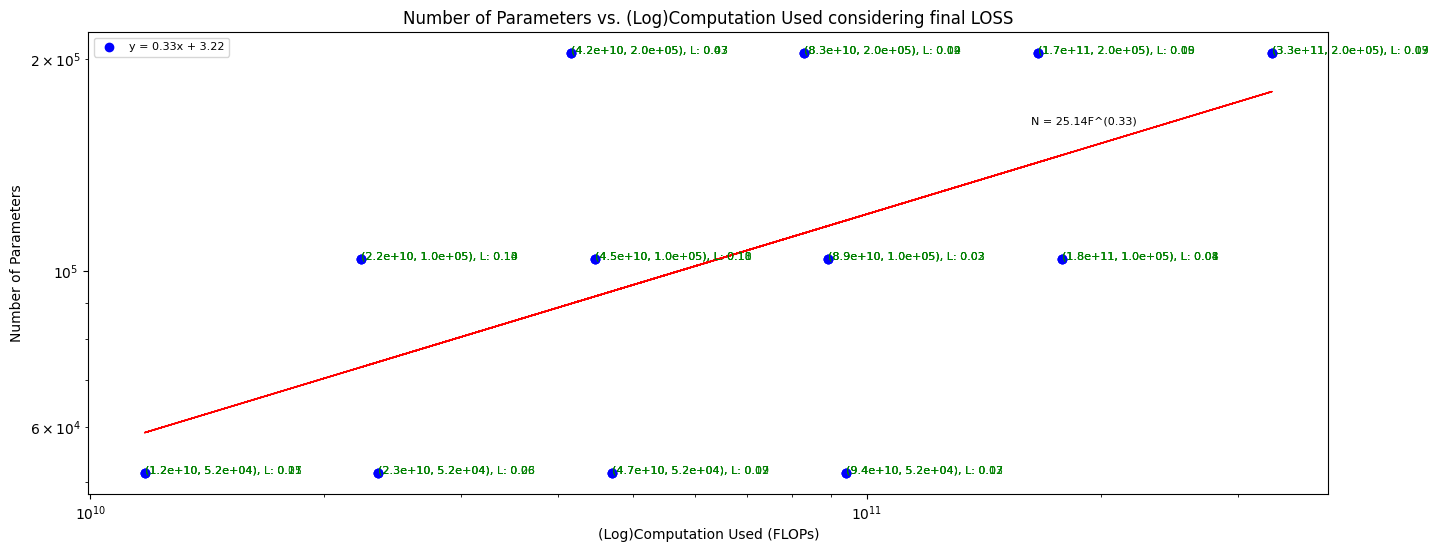

In [165]:
# for each flop, deeterminate what is the number of parameters N of the most efficient model (with low loss)
# final flops
FLOPS = [result[5][-1][0] for result in results]
XY=[]

for flop in FLOPS:
    results_for_flop = [result for result in results if result[5][-1][0] == flop]
    best_result = min(results_for_flop, key=lambda x: x[5][-1][1])
    # print(f"FLOPs: {flop}, Number of Parameters: {sum(p.numel() for p in best_result[4].parameters())}")
    XY.append((flop, sum(p.numel() for p in best_result[4].parameters())) )

X, Y = zip(*XY)

plt.figure(figsize=(16, 6))
plt.scatter(X, Y, c='b', marker='o')
plt.xlabel('(Log)Computation Used (FLOPs)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters vs. (Log)Computation Used considering final LOSS')
vals = []
for i, txt in enumerate(Y):
    plt.annotate(f"({X[i]:.1e}, {txt:.1e}), L: {results[i][5][-1][1]:.2f}", (X[i], Y[i]), fontsize=8, color='green')
    vals.append((X[i], txt, results[i][5][-1][1]))

least_loss = np.inf
pairs = []
for i in range(len(vals)):
    if vals[i][2] < least_loss:
        least_loss = vals[i][2]
        best_pair = vals[i]
    pairs.append(vals[i])
# fit power law

logX = np.log(X)
logY = np.log(Y)
m, b = np.polyfit(logX, logY, 1)
plt.plot(X, np.exp(b)*X**m, color='red', linestyle='--', linewidth=1,  label='y = {:.2f}x + {:.2f}'.format(m, b))
plt.legend(['y = {:.2f}x + {:.2f}'.format(m, b)], fontsize=8)
# plot power law eq
plt.text(0.76, 0.8, f'N = {np.exp(b):.2f}F^({m:.2f})', fontsize=8, transform=plt.gca().transAxes)
plt.show()


In [ ]:
# for each flop, deeterminate what is the number of parameters N of the most efficient model (with low loss)
# final flops
FLOPS = [result[5][-1][0] for result in results]
XY=[]

for flop in FLOPS:
    results_for_flop = [result for result in results if result[5][-1][0] == flop]
    best_result = min(results_for_flop, key=lambda x: x[5][-1][1])
    # print(f"FLOPs: {flop}, Number of Parameters: {sum(p.numel() for p in best_result[4].parameters())}")
    XY.append((flop, sum(p.numel() for p in best_result[4].parameters())) )

X, Y = zip(*XY)

plt.figure(figsize=(16, 6))
plt.scatter(X, Y, c='b', marker='o')
plt.xlabel('Computation Used (FLOPs)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters vs. Computation Used considering final LOSS')
vals = []
for i, txt in enumerate(Y):
    plt.annotate(f"({X[i]:.1e}, {txt:.1e}), L: {results[i][5][-1][1]:.2f}", (X[i], Y[i]), fontsize=8, color='green')
    vals.append((X[i], txt, results[i][5][-1][1]))

least_loss = np.inf
pairs = []
for i in range(len(vals)):
    if vals[i][2] < least_loss:
        least_loss = vals[i][2]
        best_pair = vals[i]
    pairs.append(vals[i])
# fit power law

logX = np.log(X)
logY = np.log(Y)
m, b = np.polyfit(logX, logY, 1)
plt.plot(X, np.exp(b)*X**m, color='red', linestyle='--', linewidth=1,  label='y = {:.2f}x + {:.2f}'.format(m, b))
plt.legend(['y = {:.2f}x + {:.2f}'.format(m, b)], fontsize=8)
# plot power law eq
plt.text(0.76, 0.8, f'N = {np.exp(b):.2f}F^({m:.2f})', fontsize=8, transform=plt.gca().transAxes)
plt.show()


# 6 - Repeat your entire experiment with 20% dropout to see how this affects the scaling exponents.


In [24]:
DROPOUT_RATE = 0.2

results_with_dropout = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(random_seed, model_size, dataset_fraction, dropout=DROPOUT_RATE) for random_seed, model_size, dataset_fraction in config)


In [25]:
max_acc_dropout = max(results_with_dropout, key=lambda x: x[3])
print(f"Max Accuracy: {max_acc_dropout[3]}")
print(f"Random Seed: {max_acc_dropout[0]}, Model Size: {[int(max_acc_dropout[1]* param) for param in model_sizes]}, Dataset Fraction: {max_acc_dropout[2]}, Final Loss: {max_acc_dropout[5][-1][1]}, FLOPs: {max_acc_dropout[5][-1][0]}")


Max Accuracy: 0.9858333333333333
Random Seed: 1, Model Size: [4, 5, 8], Dataset Fraction: 1, Final Loss: 0.27197131514549255, FLOPs: 332206488000


## 6.4: Amount of compute use

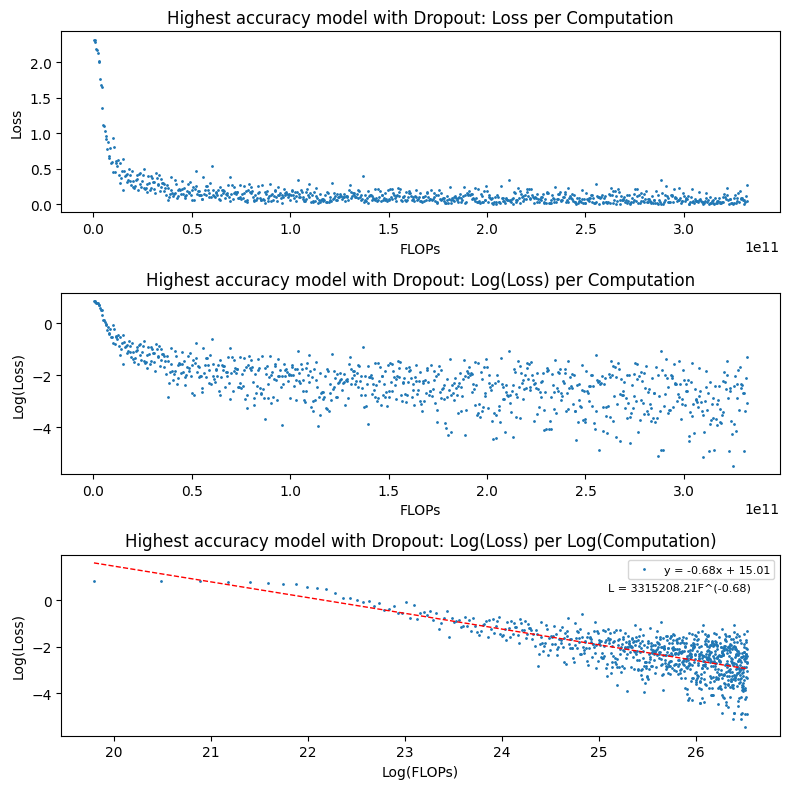

In [26]:
# For the highest accuracy model with dropout, plot the loss vs. computation used
flops_values_dropout = [max_acc_dropout[5][i][0] for i in range(len(max_acc_dropout[5]))]
loss_values_dropout = [max_acc_dropout[5][i][1] for i in range(len(max_acc_dropout[5]))]

plot_loss_vs_flops(flops_values_dropout, loss_values_dropout, title='Highest accuracy model with Dropout: ')



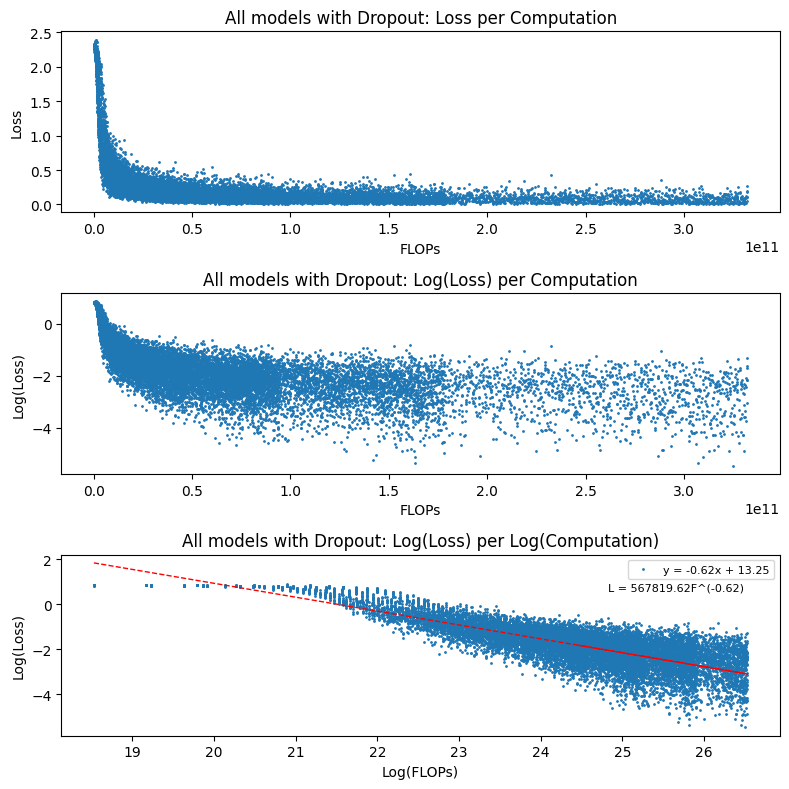

In [27]:
all_flops_drop = []
all_losses_drop = []

for result in results_with_dropout:
    flops, losses = zip(*result[5])
    all_flops_drop.extend(flops)
    all_losses_drop.extend(losses)


plot_loss_vs_flops(all_flops_drop, all_losses_drop, MK_SIZE=1, title='All models with Dropout: ')


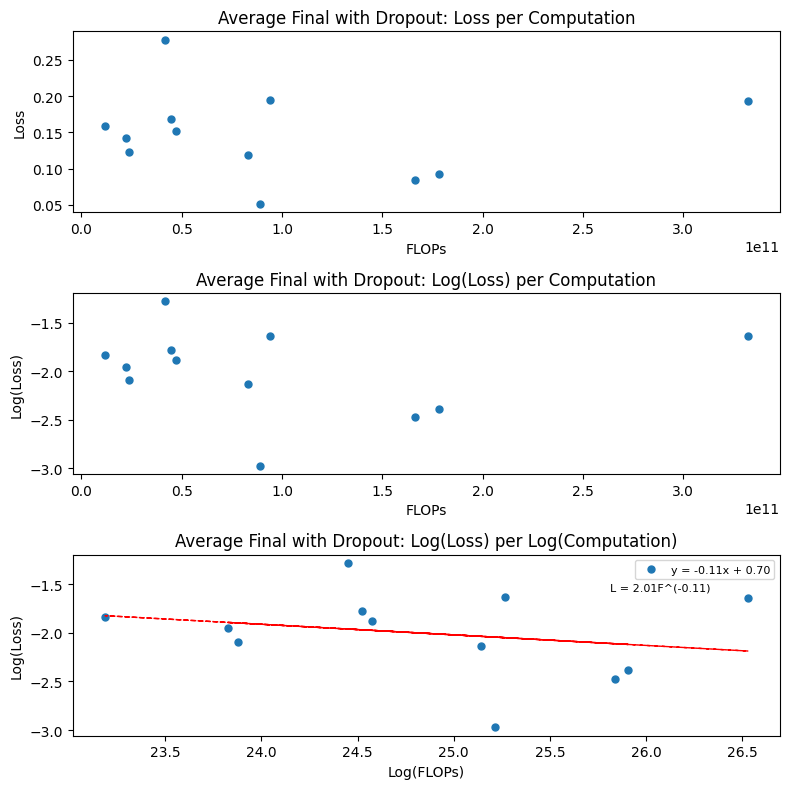

In [28]:
# average the results for models with dropout 
results_without_model_with_final_loss_drop = [(result[0], result[1], result[2], result[3], result[5][-1][0], result[5][-1][1]) for result in results_with_dropout]

average_results_drop = []
for model_size in model_sizes:
    for dataset_fraction in dataset_fractions:
        results_for_model_size_and_dataset_fraction = [result for result in results_without_model_with_final_loss_drop if result[1] == model_size and result[2] == dataset_fraction]
        average_loss = np.mean([result[5] for result in results_for_model_size_and_dataset_fraction])
        average_flops = np.mean([result[4] for result in results_for_model_size_and_dataset_fraction])
        average_accuracy = np.mean([result[3] for result in results_for_model_size_and_dataset_fraction])
        average_results_drop.append((model_size, dataset_fraction, average_accuracy, average_flops, average_loss))

# plot the average loss vs average flops
average_flops_drop = [result[3] for result in average_results_drop]
average_loss_drop = [result[4] for result in average_results_drop]

plot_loss_vs_flops(average_flops_drop, average_loss_drop, MK_SIZE=5, title='Average Final with Dropout: ')


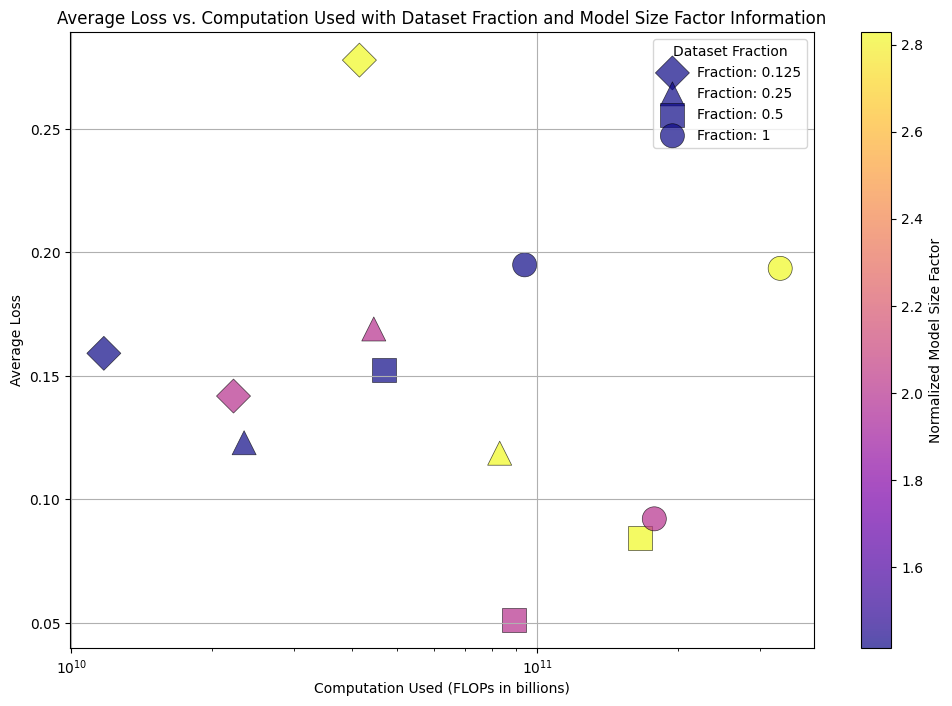

In [29]:
# plot the big grph
plot_big_graph(average_results_drop, model_sizes)


## 6.5 - Validation accuracy

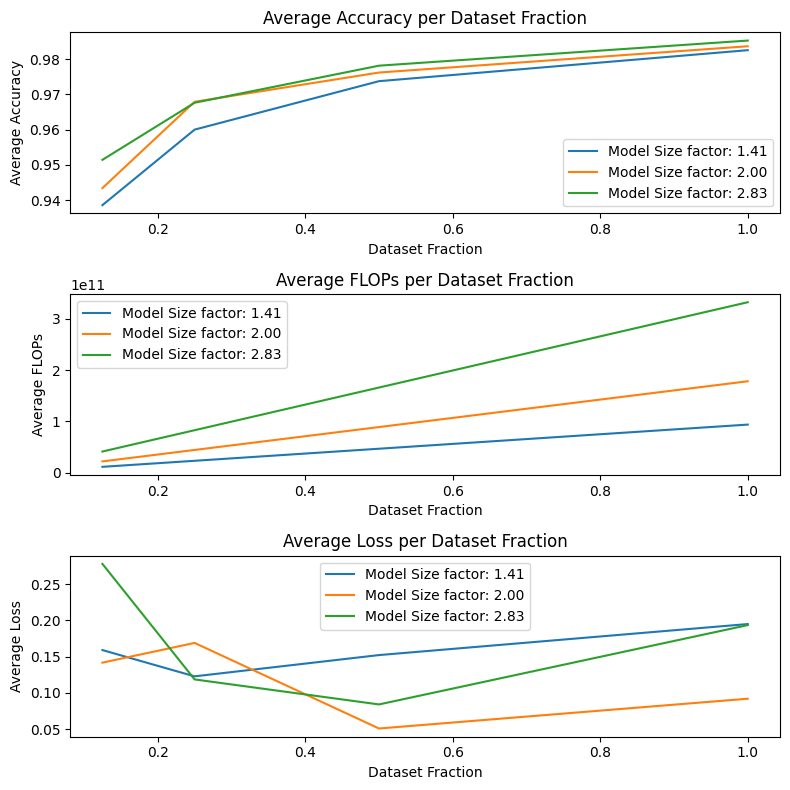

In [30]:
# plot
average_acc_per_dataset_fraction(average_results_drop, model_sizes)




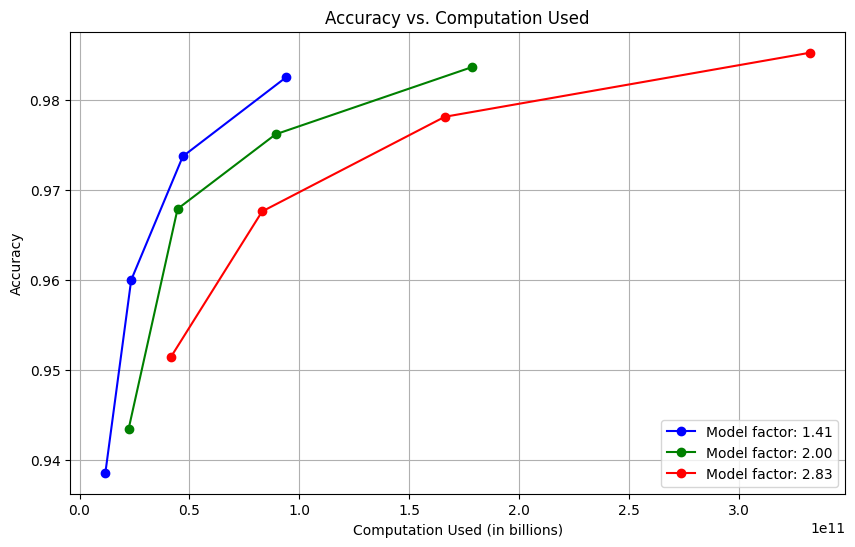

In [31]:
plot_accuracy_per_computation(average_results_drop)

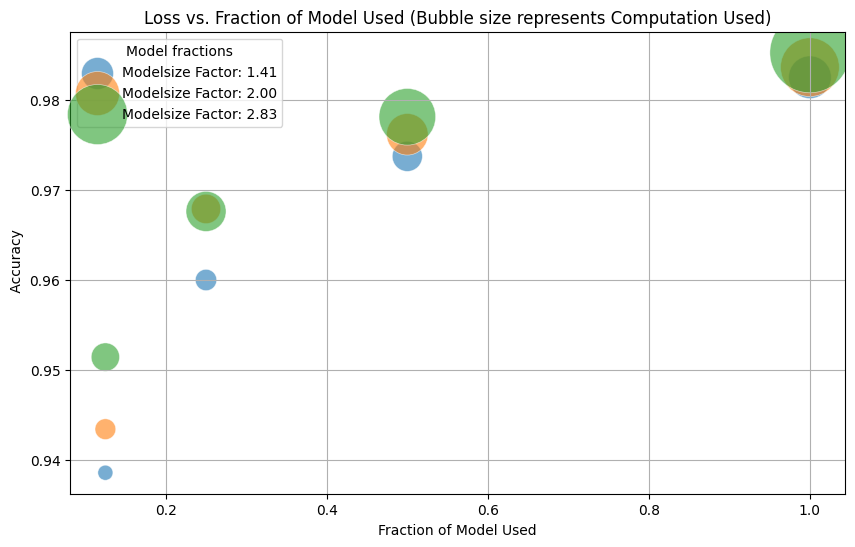

In [32]:
# plot the bubble plot
bubble_plot(average_results_drop)

## 6.5 - Study how the compute-efficient model size varies with compute. This should also follow an approximate power law. Try to estimate its exponent.


(93962160000.0, 51512, 0.10998919606208801)
(46981080000.0, 51512, 0.1210772916674614)
(23490540000.0, 51512, 0.09667401760816574)
(11745270000.0, 51512, 0.10277296602725983)
(178329600000.0, 103898, 0.1414620727300644)
(89164800000.0, 103898, 0.025638500228524208)
(44582400000.0, 103898, 0.20643743872642517)
(22291200000.0, 103898, 0.20511981844902039)
(332206488000.0, 204161, 0.1940983682870865)
(166103244000.0, 204161, 0.039506468921899796)
(83051622000.0, 204161, 0.14972062408924103)
(41525811000.0, 204161, 0.14750467240810394)


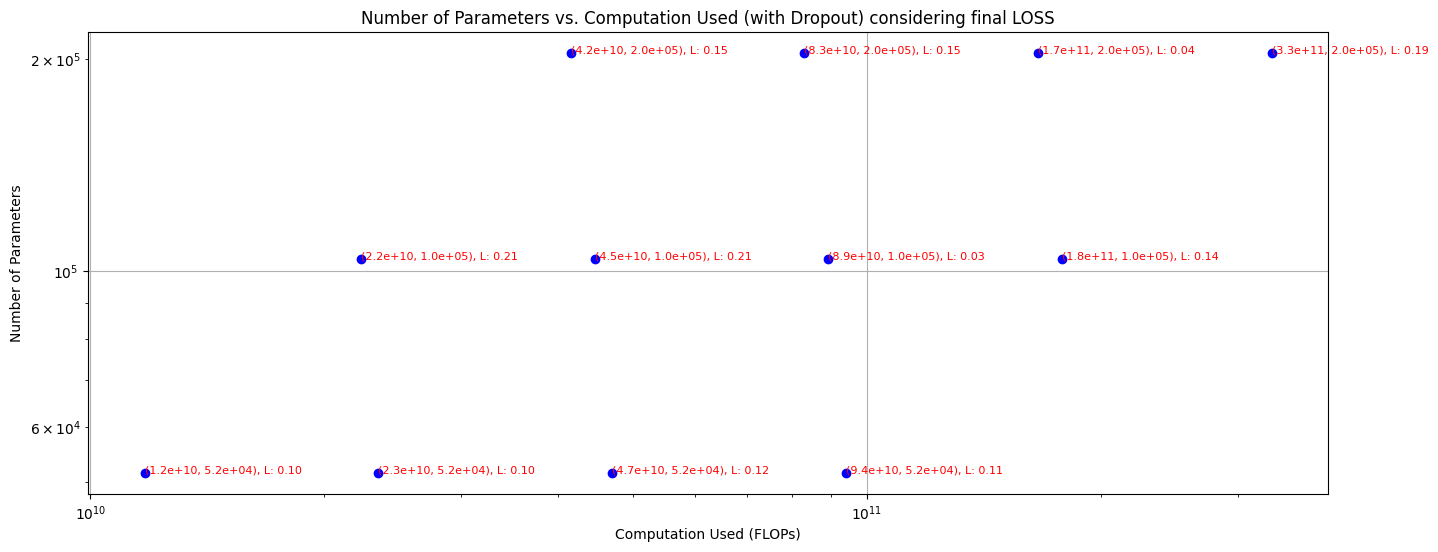

In [159]:
# for each flop, deeterminate what is the number of parameters N of the most efficient model (with low loss)
FLOPS = [result[3] for result in average_results_drop]
XY = []

for flop in FLOPS:
    results_for_flop = [result for result in results_with_dropout if result[5][-1][0] == flop]
    best_result = min(results_for_flop, key=lambda x: x[5][-1][1])
    XY.append((flop, sum(p.numel() for p in best_result[4].parameters())) )

X, Y = zip(*XY)

plt.figure(figsize=(16, 6))
plt.scatter(X, Y, c='b', marker='o')
plt.xlabel('Computation Used (FLOPs)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters vs. Computation Used (with Dropout) considering final LOSS')
# show the pair "(x,y)"" per each point, limimtating the number of digits, and also its corresponding value of loss
vals = []
for i, txt in enumerate(Y):
    plt.annotate(f"({X[i]:.1e}, {txt:.1e}), L: {results_with_dropout[i][5][-1][1]:.2f}", (X[i], Y[i]), fontsize=8, color='red')
    vals.append((X[i], txt, results_with_dropout[i][5][-1][1]))

least_loss = np.inf
pairs = []
for i in range(len(vals)):
    if vals[i][2] < least_loss:
        least_loss = vals[i][2]
        best_pair = vals[i]
    pairs.append(vals[i])

for pair in pairs:
    print(pair)
    


plt.grid(True)
plt.show()





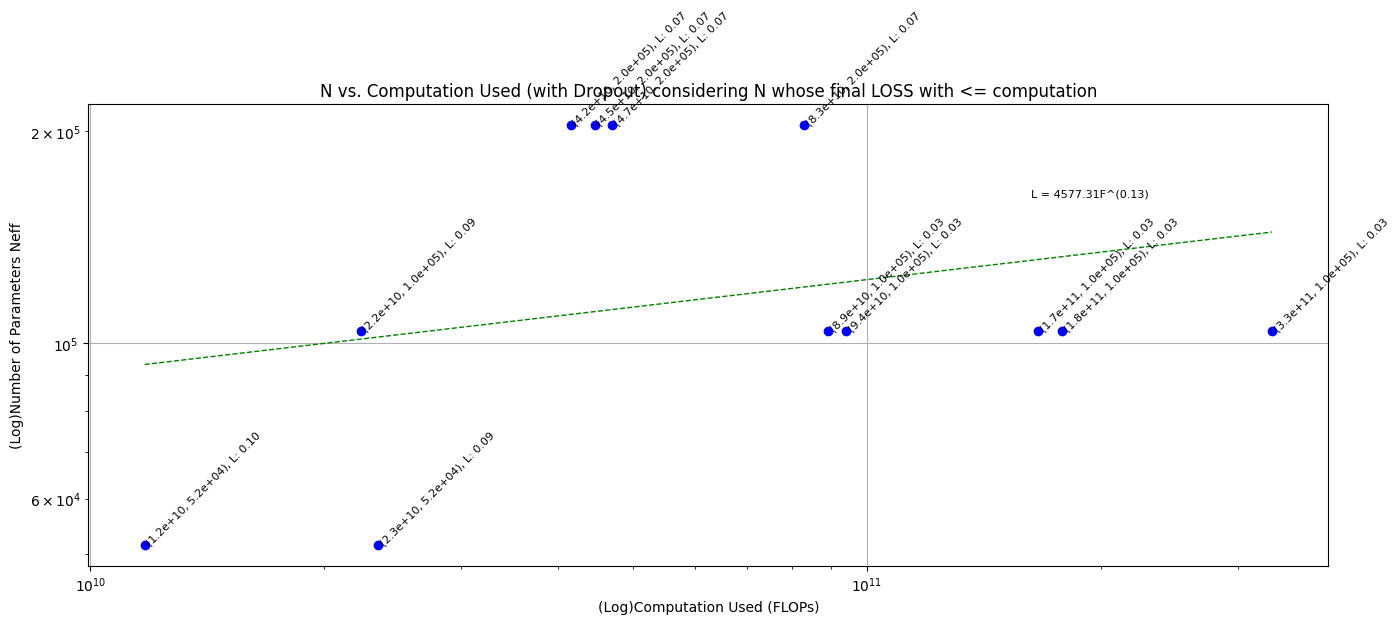

In [141]:
# for each computation used, plot the minimum loss obtained whose computation is <= than the current computation
unique_flops = sorted(set(FLOPS))
N = len(unique_flops)
NS = []

for i, flop in enumerate(unique_flops):
    results_for_flop = [result for result in results_with_dropout if result[5][-1][0] <= flop]
    best_final_loss_index = np.argmin([result[5][-1][1] for result in results_for_flop])
    best_result = results_for_flop[best_final_loss_index]
    # print(f"FLOPs: {flop}, Number of Parameters: {sum(p.numel() for p in best_result[4].parameters())}, Loss: {best_result[5][-1][1]}")
    NS.append((flop, sum(p.numel() for p in best_result[4].parameters()), best_result[5][-1][1]))

X, Y, Z = zip(*NS)

plt.figure(figsize=(16, 6))
plt.scatter(X, Y, c='b', marker='o')
plt.xlabel('(Log)Computation Used (FLOPs)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('(Log)Number of Parameters Neff')
plt.title('N vs. Computation Used (with Dropout) considering N whose final LOSS with <= computation')
for i, txt in enumerate(Y):
    plt.annotate(f"({X[i]:.1e}, {txt:.1e}), L: {Z[i]:.2f}", (X[i], Y[i]), fontsize=8, color='black', rotation=45)
plt.grid(True)
x = np.log(X)
y = np.log(Y)
m, b = np.polyfit(x, y, 1)
plt.plot(X, np.exp(m*np.log(X) + b), color='green', linestyle='--', linewidth=1)
A = np.exp(b)
B = m
plt.text(0.76, 0.8, f'L = {A:.2f}F^({B:.2f})', fontsize=8, transform=plt.gca().transAxes)

plt.show()
    

FLOPs: 93962160000.0, Number of Parameters: 51512
FLOPs: 46981080000.0, Number of Parameters: 51512
FLOPs: 23490540000.0, Number of Parameters: 51512
FLOPs: 11745270000.0, Number of Parameters: 51512
FLOPs: 178329600000.0, Number of Parameters: 103898
FLOPs: 89164800000.0, Number of Parameters: 103898
FLOPs: 44582400000.0, Number of Parameters: 103898
FLOPs: 22291200000.0, Number of Parameters: 103898
FLOPs: 332206488000.0, Number of Parameters: 204161
FLOPs: 166103244000.0, Number of Parameters: 204161
FLOPs: 83051622000.0, Number of Parameters: 204161
FLOPs: 41525811000.0, Number of Parameters: 204161


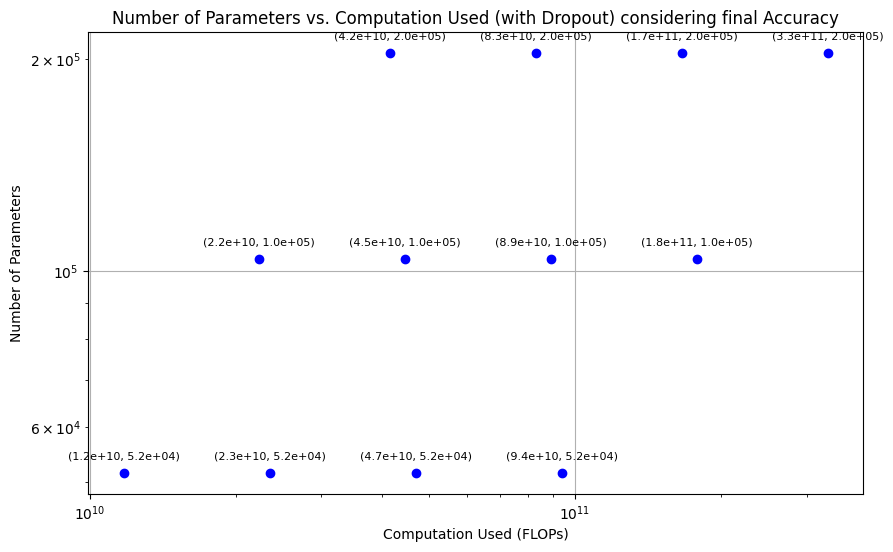

In [87]:
# number of parameters vs compute, considering accuracy per computation for efficient 
FLOPS = [result[3] for result in average_results_drop]
XY = []

for flop in FLOPS:
    results_for_flop = [result for result in results_with_dropout if result[5][-1][0] == flop]
    best_result = max(results_for_flop, key=lambda x: x[3])
    # print(f"FLOPs: {flop}, Number of Parameters: {sum(p.numel() for p in best_result[4].parameters())}")
    XY.append((flop, sum(p.numel() for p in best_result[4].parameters())) )

X, Y = zip(*XY)

plt.figure(figsize=(10, 6))
plt.scatter(X, Y, c='b', marker='o')
plt.xlabel('Computation Used (FLOPs)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters vs. Computation Used (with Dropout) considering final Accuracy')
# show the pair "(x,y)"" per each point, limimtating the number of digits
for i, txt in enumerate(Y):
    plt.annotate(f"({X[i]:.1e}, {txt:.1e})", (X[i], txt), fontsize=8, textcoords="offset points", xytext=(0,10), ha='center')
plt.grid(True)
plt.show()


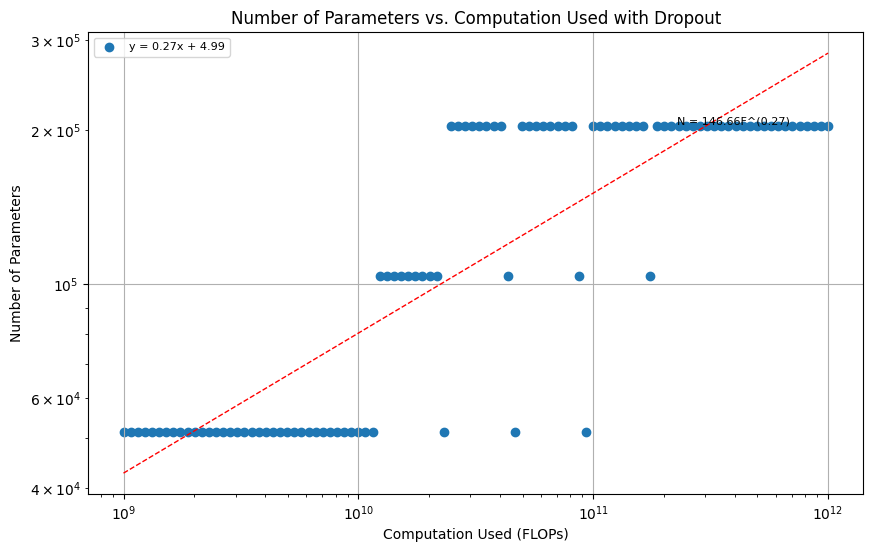

In [158]:
# Study how the compute-efficient model size varies with compute. This should also follow an approximate power law. Try to estimate its exponent.
# given compute, performs better

# given a compute, get the most efficient model
def get_most_efficient_model(results, flops):
    # get the model with the lowest loss for a given compute
    models_with_flops = [(result, result[5][-1][0]) for result in results]
    models_with_flops = sorted(models_with_flops, key=lambda x: x[1])
    for model, model_flops in models_with_flops:
        if model_flops > flops:
            return model
    return models_with_flops[-1][0]

most_efficient_model = get_most_efficient_model(results_with_dropout, 1e9)
most_efficient_model_size = sum(p.numel() for p in most_efficient_model[4].parameters())

# vary the compute and get the most efficient model for each compute and plot the graph of model size vs compute
computation_values = np.logspace(9, 12, 100)
model_sizes = []
for comp in computation_values:
    model = get_most_efficient_model(results_with_dropout, comp)
    model_size = sum(p.numel() for p in model[4].parameters())
    model_sizes.append(model_size)

plt.figure(figsize=(10, 6))
plt.scatter(computation_values, model_sizes)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Computation Used (FLOPs)')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters vs. Computation Used with Dropout')
plt.grid(True)

# add line 
logX = np.log(computation_values)
logY = np.log(model_sizes)
m, b = np.polyfit(logX, logY, 1)
plt.plot(computation_values, np.exp(b)*computation_values**m, color='red', linestyle='--', linewidth=1,  label='y = {:.2f}x + {:.2f}'.format(m, b))
plt.legend(['y = {:.2f}x + {:.2f}'.format(m, b)], fontsize=8)
plt.text(0.76, 0.8, f'N = {np.exp(b):.2f}F^({m:.2f})', fontsize=8, transform=plt.gca().transAxes)
plt.show()
